### 目的
- 为了使用 GPytorch 来替代 sklearn.gaussian_process

In [1]:
import torch
import gpytorch
import numpy as np
from gaussian_process import GaussianProcessWrapper
from sklearn.gaussian_process import GaussianProcessRegressor
from gym_pybullet_drones.utils.utils import *
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

pybullet build time: Nov 28 2023 23:45:17


In [2]:
observed_point = [[0,0.1,0.0],[0,0.2,0.1],[0,0.3,0.2],[0,0.4,0.3]]
def show_heatmap(data):
    plt.imshow(data.reshape((40,40)),cmap='viridis',aspect='equal',vmin=0,vmax=1)

In [3]:
gp_sklearn = GaussianProcessWrapper(6,[1,2,3,4,5],None,0,use_gpytorch=False)
for point in observed_point:
    for gp in gp_sklearn.GPs:
        gp.add_observed_point(np.array(point).reshape((-1,3)),np.array(1.0))

In [4]:
gp_sklearn.update_GPs()
all_pred,all_std,_ = gp_sklearn.update_grids(0.1)

In [5]:
print(np.max(all_pred))
print(np.min(all_std))
gp_sklearn.GPs: list[GaussianProcessRegressor]
print(gp_sklearn.GPs[0].kernel)

0.9749087338016537
0.41529223712489316
Matern(length_scale=[0.1, 0.1, 3], nu=1.5)


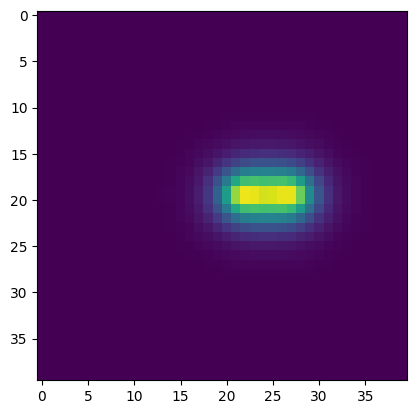

In [6]:
show_heatmap(all_pred)
# show_heatmap(all_std)

### 
这里使用一个 gpytoch 版本实现的 gp

In [7]:
gp_torch = GaussianProcessWrapper(6,[1,2,3,4,5],None,0,use_gpytorch=True)
for point in observed_point:
    for gp in gp_torch.GPs:
        gp.add_observed_point(np.array(point).reshape((-1,3)),np.array(1.0))

In [8]:
gp_torch.update_GPs()
all_pred_torch,all_std_torch,_ = gp_torch.update_grids(0.1)

In [9]:
data = np.asarray([0,0.4,0.4]).reshape(1,-1)
gpy = gp_torch.GPs[0].gp_torch
a = gpy.predict(torch.from_numpy(data).cuda())

In [10]:
gpy.likelihood.noise_covar.noise

tensor([1.0000e-10], device='cuda:0')

In [11]:
a.covariance_matrix


tensor([[0.0032]], device='cuda:0', dtype=torch.float64)

In [12]:
sk = gp_sklearn.GPs[0].gp
sk.predict(data,return_std=True)

(array([0.99833732]), array([0.05661431]))

In [13]:
sk.alpha_

array([[0.75071146],
       [0.35913353],
       [0.35913353],
       [0.75071146]])

In [14]:
sk.kernel_(data,data) + sk.alpha * np.eye(len(data))

array([[1.]])

In [15]:
print(np.max(all_pred_torch))
print(np.min(all_std_torch))
print(gp_torch.GPs[0].gp_torch.covar_module.raw_lengthscale)

0.9749087354780854
0.4152922321897346
Parameter containing:
tensor([0.1000, 0.1000, 3.0000], device='cuda:0')


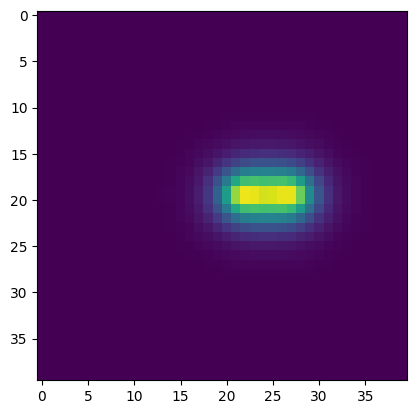

In [16]:
show_heatmap(all_pred_torch)
# show_heatmap(all_std_torch)

检查核矩阵

In [17]:
gp_sklearn.GPs[0].kernel(observed_point)

array([[1.        , 0.483063  , 0.13952288, 0.0342303 ],
       [0.483063  , 1.        , 0.483063  , 0.13952288],
       [0.13952288, 0.483063  , 1.        , 0.483063  ],
       [0.0342303 , 0.13952288, 0.483063  , 1.        ]])

In [18]:
gp_torch.GPs[0].gp_torch.covar_module(torch.from_numpy(np.asarray(observed_point)).cuda()).detach().cpu().numpy()

array([[1.        , 0.48306301, 0.13952288, 0.0342303 ],
       [0.48306301, 1.        , 0.48306301, 0.13952288],
       [0.13952288, 0.48306301, 1.        , 0.48306301],
       [0.0342303 , 0.13952288, 0.48306301, 1.        ]])

In [19]:
test_x = add_t(gp_sklearn.GPs[0].grid,1)

In [20]:
with torch.no_grad():
    a = gp_torch.GPs[0].gp_torch(torch.from_numpy(test_x).cuda()).mean

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
a.max()

NameError: name 'a' is not defined

In [ ]:
import pickle

with open("sklearn.pickle", "rb") as file:
    sk = pickle.load(file)
with open("gpytorch.pickle", "rb") as file:
    gp = pickle.load(file)

In [ ]:
data = np.asarray([0,0.4,0.4]).reshape(1,-1)

In [ ]:
sk.predict(data)

array([0.99833732])

In [ ]:
print(sk.X_train_)

print(sk.alpha_)

[[0.  0.1 0. ]
 [0.  0.2 0.1]
 [0.  0.3 0.2]
 [0.  0.4 0.3]]
[[0.75071146]
 [0.35913353]
 [0.35913353]
 [0.75071146]]


In [ ]:
gp.predict(torch.from_numpy(data).cuda()).mean

AttributeError: 'tuple' object has no attribute 'lazy_covariance_matrix'

In [ ]:

print(gp.train_inputs)

mean = gp.mean_module(torch.from_numpy(data).cuda())
print(mean)
std = gp.covar_module(mean)
print()

[tensor([[0.0000, 0.1000, 0.0000],
        [0.0000, 0.2000, 0.1000],
        [0.0000, 0.3000, 0.2000],
        [0.0000, 0.4000, 0.3000]], device='cuda:0', dtype=torch.float64)]
tensor([0.], device='cuda:0', grad_fn=<ExpandBackward0>)


RuntimeError: Expected the input to have 3 dimensionality (based on the ard_num_dims argument). Got 1.